# Top Business Options in Ecuadorian Capital Cities
## Applied Data Science Capstone by IBM/Coursera

(Written by: D. Espinosa, November 2020)

## Table of contents

* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a class="anchor" id="introduction"></a>

This project beomes the Capstone in "Applied Data Science" course, the final one in "IBM Data Science" Professional Certificate program. In this project, we will find the **top business options in each Capital City of Ecuador, and the similarity of each market based on available venues**, so any startup entrepreneur can have a quick idea of what to invest and where, depending their current location of residence.

## Data <a class="anchor" id="data"></a>

Following data sources will be needed to extract/generate the required information:
* **Capital citites in Ecuador**, scrapped from [Wikipedia](https://es.wikipedia.org/wiki/Provincias_de_Ecuador), using [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).
* **Geographical locations** will be extracted using [GeoPy](https://geopy.readthedocs.io/en/stable/).
* **Number of venues and their type**, in every town will be obtained using [Foursquare API](https://developer.foursquare.com/docs/api-reference/venues/search/).

### Data Extraction

First, we start by importing all the libraries needed:

In [1]:
# IMPORTANT: Please check the libraries used in this cell, and make sure you have all of the installed;
#            If you get an error, check the library that caused the error, and uncomment here to install.

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you don't have FOLIUM
# !conda install -c conda-forge geopy --yes        # uncomment this line if you don't have GEOPY
# !pip install yellowbrick                         # uncomment this line if you don't have YELLOWBRICK

# IMPORTING LIBRARIES

import requests
import geocoder
import os
import json
import random
import folium
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

# IMPORTING SPECIFIC MODULES

from geopy.geocoders import Nominatim            # convert an address into latitude and longitude values
from pandas.io.json import json_normalize        # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup                    # scrapping
from sklearn.cluster import KMeans               # clustering algorithm
from scipy.spatial.distance import cdist         # euclidean distance between 2 set of vectors
from yellowbrick.cluster import KElbowVisualizer # determine correct number of cluster

pd.set_option('max_colwidth', 800)               # To ensure good visualization
print('Libraries imported.')

Libraries imported.


Next, we proceed to scrap the Provinces & Capital Cities in Ecuador, from Wikipedia; we also drop some columns that will not be of interest for the search we are carrying on:

In [2]:
# Web scrapping:
req = requests.get("https://es.wikipedia.org/wiki/Provincias_de_Ecuador")
soup = BeautifulSoup(req.content,'html5lib')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0] # Preliminary dataframe
print('Dataframe loaded!\n\nThe original columns in the dataset are:')
[print(i) for i in list(df.columns)]

# Redundant / useless columns to drop:
col_to_drop = ['Población','Área','Densidad','Hab. (2020)[3]​','Área (km²)','Densidad (hab./km²)',
               'Cantones','Fundación','Bandera','#']
print('\nThe following columns will be dropped:')
[print(i) for i in col_to_drop]
df.drop(labels=col_to_drop,axis=1,inplace=True)

# Renaming columns to English:
dict_rename = {'Provincia':'Province','Capital':'City','Hab. (2010)':'Population'}
df.rename(columns=dict_rename,inplace=True)

print('\nCurrent dataframe shape:',df.shape,'\n\nDisplaying first five rows:\n')
df.head()

Dataframe loaded!

The original columns in the dataset are:
Población
Área
Densidad
Provincia
Hab. (2020)[3]​
Área (km²)
Densidad (hab./km²)
Cantones
Fundación
Bandera
Capital
Hab. (2010)
#

The following columns will be dropped:
Población
Área
Densidad
Hab. (2020)[3]​
Área (km²)
Densidad (hab./km²)
Cantones
Fundación
Bandera
#

Current dataframe shape: (24, 3) 

Displaying first five rows:



,Province,City,Population
0,Azuay,Cuenca,329 928
1,Bolívar,Guaranda,23 874
2,Cañar,Azogues,33 848
3,Carchi,Tulcán,53 558
4,Chimborazo,Riobamba,146 324


As we can see, it is a relatively small dataset. We will start by populating it with the surface area of each capital. I will scrap these results from Wikipedia, and see how it looks:

In [3]:
# We keep scrapping to obtain the surface per each city:
kms = {}

# Scrapping the links to each city's wikipedia article
print('Scrapping surface of the following cities, please wait\n',end='')
for p,trs in enumerate(table.find_all('tr')):
    for c,tds in enumerate(trs.find_all('td')):
        print('.',end='') # To display ongoing process
        if c == 10:
            fl = 'https://es.wikipedia.org'+tds.a['href']
            req = requests.get(fl)
            soup = BeautifulSoup(req.content,'html5lib')
            table1 = soup.find_all('table')[0]
            for i,trs in enumerate(table1.find_all('tr')):
                try:
                    kms[df.loc[p-1,'City']]=np.NaN
                    if trs.th.a.string == 'Superficie':
                        a = table1.find_all('tr')[i+1].td.get_text().split()[0]
                        kms[df.loc[p-1,'City']]=a
                        break
                except:
                    pass

# Reconstructing on original dataframe:
dfkm = pd.DataFrame.from_dict(kms,orient='index',columns=['KM2'])
dfkm.reset_index(inplace=True)
dfkm.rename(columns={'index':'City'},inplace=True)
print('\n\nSurface areas scrapped! Displaying first five rows:\n\n',dfkm.head(),
      '\n\nMerging with previous Dataframe, and displaying first five rows:\n')

# Merging results:
df = pd.merge(df,dfkm,on='City')
df.head()

Scrapping surface of the following cities, please wait
........................................................................................................................................................................................................................................................................................................................

Surface areas scrapped! Displaying first five rows:

        City     KM2
0    Cuenca     124
1  Guaranda  519,56
2   Azogues   60,94
3    Tulcán      15
4  Riobamba   28,13 

Merging with previous Dataframe, and displaying first five rows:



,Province,City,Population,KM2
0,Azuay,Cuenca,329 928,124
1,Bolívar,Guaranda,23 874,"519,56"
2,Cañar,Azogues,33 848,"60,94"
3,Carchi,Tulcán,53 558,15
4,Chimborazo,Riobamba,146 324,"28,13"


We need to check if the current dataframe is actually full, or we need to fill any blank:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Province    24 non-null     object
 1   City        24 non-null     object
 2   Population  24 non-null     object
 3   KM2         22 non-null     object
dtypes: object(4)
memory usage: 960.0+ bytes


We notice that we have 2 empty values in 'KM2' column; let's check which are those values:

In [5]:
df[df['KM2'].isna()]

,Province,City,Population,KM2
11,Loja,Loja,170 280,NaN
22,Tungurahua,Ambato,165 185,NaN


Since it is mandatory to have all values filled, we manually check and insert those values, and make sure we have numeric values in 'KM2':

In [6]:
# Filling empty spaces
df.loc[11,'KM2'] = '285,7' # Loja
df.loc[22,'KM2'] = '46,5'  # Ambato

df['KM2'] = df['KM2'].apply(lambda x:float(x.replace(',','.')))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Province    24 non-null     object 
 1   City        24 non-null     object 
 2   Population  24 non-null     object 
 3   KM2         24 non-null     float64
dtypes: float64(1), object(3)
memory usage: 1.6+ KB


Now that we know thet column 'KM2' is numeric, we obtain an approximate 'SearchRadius' on each city, and then drop 'KM2'; 'SearchRadius' value will be useful later, to scale the radius of venues search, depending on the size of the city:

In [7]:
df['SearchRadius'] = (np.sqrt(df['KM2'] / np.pi) * 1000).astype(int) # Search radius in meters
df.drop('KM2',axis=1,inplace=True)
df.head()

,Province,City,Population,SearchRadius
0,Azuay,Cuenca,329 928,6282
1,Bolívar,Guaranda,23 874,12860
2,Cañar,Azogues,33 848,4404
3,Carchi,Tulcán,53 558,2185
4,Chimborazo,Riobamba,146 324,2992


Now, we will look for the coordinates per each city, using GeoPy library, as follows:

In [8]:
print('Retrieving coordinates from each city, please wait...')
for c in range(df.shape[0]):
    address = df.loc[c,'City']+', '+df.loc[c,'Province']+', Ecuador'
    print(address)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    df.loc[c,'Latitude'] = location.latitude
    df.loc[c,'Longitude'] = location.longitude
df.head()

Retrieving coordinates from each city, please wait...
Cuenca, Azuay, Ecuador
Guaranda, Bolívar, Ecuador
Azogues, Cañar, Ecuador
Tulcán, Carchi, Ecuador
Riobamba, Chimborazo, Ecuador
Latacunga, Cotopaxi, Ecuador
Machala, El Oro, Ecuador
Esmeraldas, Esmeraldas, Ecuador
Puerto Baquerizo Moreno, Galápagos, Ecuador
Guayaquil, Guayas, Ecuador
Ibarra, Imbabura, Ecuador
Loja, Loja, Ecuador
Babahoyo, Los Ríos, Ecuador
Portoviejo, Manabí, Ecuador
Macas, Morona Santiago, Ecuador
Tena, Napo, Ecuador
Pto. Francisco de Orellana, Orellana, Ecuador
Puyo, Pastaza, Ecuador
Quito, Pichincha, Ecuador
Santa Elena, Santa Elena, Ecuador
Santo Domingo, Santo Domingo de los Tsáchilas, Ecuador
Nueva Loja, Sucumbíos, Ecuador
Ambato, Tungurahua, Ecuador
Zamora, Zamora Chinchipe, Ecuador


,Province,City,Population,SearchRadius,Latitude,Longitude
0,Azuay,Cuenca,329 928,6282,-2.897040,-79.003948
1,Bolívar,Guaranda,23 874,12860,-1.592290,-79.001561
2,Cañar,Azogues,33 848,4404,-2.631729,-78.700893
3,Carchi,Tulcán,53 558,2185,0.811929,-77.717108
4,Chimborazo,Riobamba,146 324,2992,-1.673148,-78.648646


Let's graph and see what were the locations retrieved, are:

In [9]:
address = 'Quito, Ecuador'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# print('The geograpical coordinate of Quito, Ecuador are {}, {}.'.format(latitude, longitude))
latitude, longitude = -0.859096, -84.888436
map_ecu = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, prov, city in zip(df['Latitude'], df['Longitude'], df['Province'], df['City']):
    label = '{}, {}'.format(prov, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ecu)  
    
map_ecu

### Data Segmentation

Now I proceed to extract the venues per each capital city, using Foursquare API to do so. First I declare some constants as well as some functions to extract these values:

In [10]:
CLIENT_ID = 'UFFXIDN5WWVHYRAEHNRGPZKUGOFF1I1MRE1ZOVCWGCDMVV0G' # your Foursquare ID
CLIENT_SECRET = 'K0PMVXYM10N5RI4UFLOOBY3CGAGCBQ3DLF3YZ3IU2UJY1HOY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

def getNearbyVenues(names, latitudes, longitudes, radiuses):   
    venues_list=[]
    for name, lat, lng, rd in zip(names, latitudes, longitudes, radiuses):
        
        # The search radius is provided by the dataframe:
        radius = rd
           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(          
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        flag = 1
        while flag == 1:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                print('{} venues found in {} city'.format(len(results),name))
                flag = 0
            except:
                print('Result could not be retrieved, retrying...')
                continue

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, I extract the venues in all capital cities in Ecuador:

In [11]:
ecu_venues = getNearbyVenues(names = df['City'],
                             latitudes = df['Latitude'],
                             longitudes = df['Longitude'],
                             radiuses=df['SearchRadius'])
print('DONE! Venues in Ecuador extracted')

83 venues found in Cuenca city
12 venues found in Guaranda city
0 venues found in Azogues city
9 venues found in Tulcán city
37 venues found in Riobamba city
12 venues found in Latacunga city
43 venues found in Machala city
8 venues found in Esmeraldas city
12 venues found in Puerto Baquerizo Moreno city
100 venues found in Guayaquil city
28 venues found in Ibarra city
85 venues found in Loja city
6 venues found in Babahoyo city
27 venues found in Portoviejo city
6 venues found in Macas city
0 venues found in Tena city
4 venues found in Pto. Francisco de Orellana city
5 venues found in Puyo city
100 venues found in Quito city
2 venues found in Santa Elena city
2 venues found in Santo Domingo city
6 venues found in Nueva Loja city
51 venues found in Ambato city
5 venues found in Zamora city
DONE! Venues in Ecuador extracted


I now drop all the non-profitable venues:

In [12]:
exc_ven = ['Park', 'Shopping Mall', 'Plaza', 'Scenic Lookout', 'Soccer Stadium', 'Historic Site', 'Theater', 'Food Court', 'Trail',
 'Multiplex', 'Church', 'History Museum', 'Movie Theater', 'Beach', 'Airport', 'Resort', 'Art Gallery', 'Art Museum', 'Bus Station',
 'Tennis Court', 'Field', 'Roof Deck', 'Pier', 'Train Station', 'River', 'Tourist Information Center', 'College Cafeteria',
 'Science Museum', 'Neighborhood', 'Lounge', 'Museum', 'Zoo', 'Basketball Stadium', 'Sculpture Garden', 'Lighthouse',
 'Construction & Landscaping',  'Pool', 'Performing Arts Venue', 'Music Venue', 'Gas Station', 'Airport Terminal', 'Sports Club',
 'Harbor / Marina', 'Theme Park Ride / Attraction', 'Professional & Other Places', 'Concert Hall', 'Surf Spot', 'Lake',
 'Nature Preserve', 'Soccer Field', 'Monument / Landmark', 'Hotel Pool']

ecu_venues = ecu_venues[~ecu_venues['Venue Category'].isin(exc_ven)]
ecu_venues.reset_index(inplace=True)
ecu_venues.drop('index',inplace=True,axis=1)
print("{} venues found".format(ecu_venues.shape[0]))
ecu_venues.head()

465 venues found


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cuenca,-2.89704,-79.003948,Tiestos,-2.900844,-79.001314,South American Restaurant
1,Cuenca,-2.89704,-79.003948,Mediterraneo,-2.901106,-79.004264,Italian Restaurant
2,Cuenca,-2.89704,-79.003948,El Mercado Cuenca,-2.901356,-79.005226,Comfort Food Restaurant
3,Cuenca,-2.89704,-79.003948,Hotel Santa Lucia,-2.897900,-79.002874,Hotel
4,Cuenca,-2.89704,-79.003948,Mangiare Bene,-2.895692,-79.009809,Italian Restaurant


We notice that there is 'little' record of venues; however it is worth to mention that this behaviour could be related with the lack of local users input that promote local businesses, mostly motivated by the limitation of mobile data in the tiniest towns, which in return take away a lot of the actual number of venues. However and since we decided to remain factual, we will continue on this analysis.

## Methodology <a class="anchor" id="methodology"></a>

At this point, it is very important to understand two things:

1. First, I need to one-hot encode all of the venues, dropping the rest of the columns; then, to have an even weight between all of the venues, I will group them, using the mean as aggregate function.
2. I will implement a function to display graphically to "the top # venues in a city", which could be used to build presentations to stakeholders, for a quick grasp of the (possibly) trending venues, but with a hig amount of competence
3. Linked to the previous info, I will implement a function to obtain a full report of the most common venues in all Ecuadorian Capital cities, for a summary view of this information,
4. I will build a function to obtain a report of the non-existent venues in each city, which could become a list of _interesting_ investment options, as there would be virtually not any competence in those fields,
5. Finally, and in a way that the customer can have not only his / her home town, but ALL Ecuadorian cities as option for a startup, we will cluster the capital cities to check which ones are similar to others; maybe opening the chance for franchises.


## Analysis <a class="anchor" id="analysis"></a>

### One Hot Encoding & Aggregating Function

The one hot encoding is done as follows:

In [13]:
# one hot encoding
ecu_onehot = pd.get_dummies(ecu_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ecu_onehot['City'] = ecu_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [ecu_onehot.columns[-1]] + list(ecu_onehot.columns[:-1])
ecu_onehot = ecu_onehot[fixed_columns]

ecu_onehot.head()

,City,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,...,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Warehouse Store,Wings Joint,Women's Store
0,Cuenca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cuenca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cuenca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cuenca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cuenca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The we proceed with the grouping:

In [14]:
ecu_grouped = ecu_onehot.groupby('City').mean().reset_index()
ecu_grouped.head()

,City,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,...,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Toy / Game Store,Vegetarian / Vegan Restaurant,Warehouse Store,Wings Joint,Women's Store
0,Ambato,0.000000,0.000000,0.000000,0.000000,0.0,0.052632,0.0,0.000000,0.026316,...,0.0,0.0,0.026316,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1,Babahoyo,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,Cuenca,0.016129,0.016129,0.032258,0.016129,0.0,0.064516,0.0,0.016129,0.000000,...,0.0,0.0,0.016129,0.016129,0.016129,0.0,0.016129,0.0,0.0,0.0
3,Esmeraldas,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,Guaranda,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.285714,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


### Visualization of top venues in some city

Let's define a function that will help us visualize the most popular venues in a city; not only that, but can help us saving 'screenshots' of the images obtained, to populate possible presentations to stakeholders afterwards.

At this point, it is important to remember that the ultimate goal of any Data Scientist, is to tell stories about the data he or she is analyzing, as addendum to their daily basis data exploration and coding activities; therefore, making sure to obtain files easily shareable must be always in the mindset of the data analyst.

In [15]:
def visual_top_venues(df,city,lim=5,savefig=False):
    
    # Get df similar to 'ecu_grouped', and choose only the parameter city
    # Reset index so we always point to index 0
    # Transpose
    # Sort to get top venues
    try:
        a = df[df['City'] == city].reset_index(drop=True).transpose().iloc[1:].sort_values(by=0,ascending=False)
    except:
        print('The city you searched might not be a Capital City in Ecuador')
        return None
    
    if a[a[0] != 0].shape[0] > lim:
        
        # Limit the number of results
        # Renaming to avoid confusion
        a = a.iloc[:lim].rename(columns={0:'Weight'})                  

        a['Weight'] = a['Weight'] * 100                   # Convert into percentage
        a['Weight'] = pd.to_numeric(a['Weight'])          # Format compatible with numpy
        a['Weight'] = a['Weight'].round(decimals=2)       # Round decimals

        title_size, lxtp_size, barwidth = 20, 14, 0.8 # Font size
        del_spine_sides = ['top','bottom','left','right'] # Which borders to eliminate on the frame (spines)
        
        r = lambda: random.randint(0,255)                 # To generate random colors every time this function is called
        color = '#%02X%02X%02X' % (r(),r(),r())
        
        plt.figure()
        plt.rcParams["axes.grid"] = False                # To hide whole grids (horizontal and vertical)
        ax = a.plot(kind='barh',figsize=(20,8),
                        color = (color),
                        width = 0.8)
        plt.gca().invert_yaxis()                          # Result were swapped along vertical axis, to compensate

        ax.set_title('Most popular venues in {} city'.format(city),fontdict={'fontsize':title_size})
        ax.legend(fontsize=lxtp_size)                     # Setting legend font size (14)
        ax.tick_params(axis='x',labelsize=lxtp_size)      # Setting xticks font size (14)
        ax.xaxis.set_visible(False)                       # Hiding yaxis labels
        ax.yaxis.label.set_size(18)
        for side in del_spine_sides:                      # Hiding 'spines' in all sides
            ax.spines[side].set_visible(False)
        plt.yticks(fontsize = lxtp_size)
        rects = ax.patches # Provides (x,y) position, width, heigth & angle af ALL the bars

        for rect in rects:                                # Adding labels on top of each bar
                width = rect.get_width()
                ax.annotate('{}%'.format(width),          # COMPLETELY DIFFERENT THAN kind='bar'
                            xy=(width,  rect.get_y() + rect.get_height() / 2),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='left', va='center',size = 14)
        plt.plot()
        if savefig:
            plt.savefig("Top {} venues in {}.jpeg".format(lim,city), dpi=150)
    else:
        print('This city does not have enough data to display.')
    return None

OK, lets test the previously created function tweaking the parameters:

<Figure size 576x396 with 0 Axes>

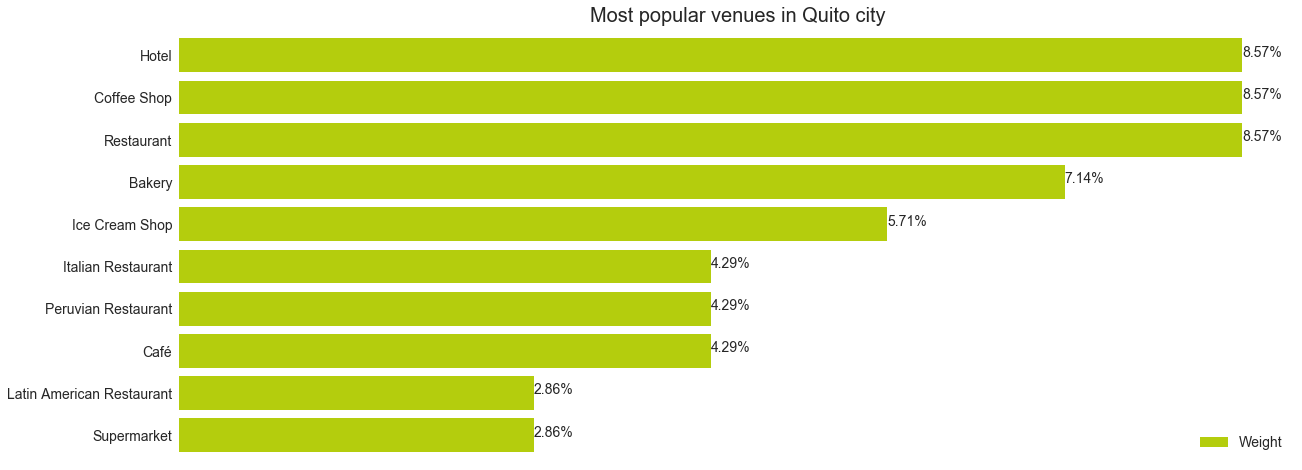

In [16]:
# Top 10 venues in Quito City
visual_top_venues(ecu_grouped,'Quito',lim=10,savefig=True)

To make sure of differenciate the results and not be monotonous, I have decided to obtain a random color every time a graph is obtained; it is worth to remember that color, as well as other aspects, can impact the quality of your presentation, so make sure to refine these details in your final results preparation. For the purpose of this exploratory analysis, it will work. Let's try the defaults of the function now:

<Figure size 576x396 with 0 Axes>

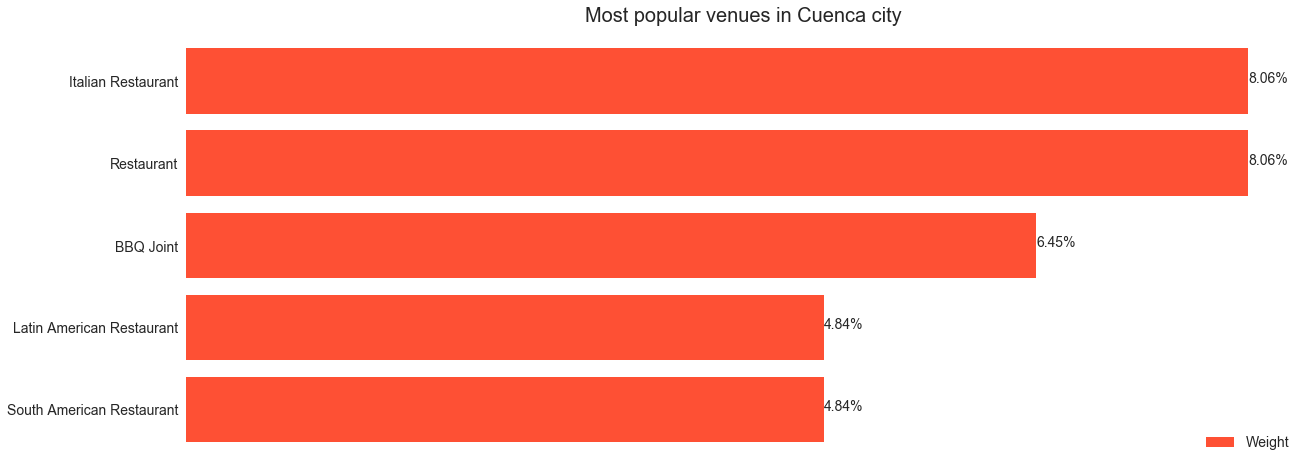

In [17]:
# If we insert no parameter 'lim',we obtain by default the top 5 venues in the corresponding city:
visual_top_venues(ecu_grouped,'Cuenca')

### Report of top venues in every capital city in Ecuador

Of course, we could also have a glimpse of the top venues in a city, with another function, for a quick check:

In [18]:
def get_ecu_top_venues_report(df,lim=5,popular_venues=True):
    # create columns according to number of top venues
    columns = ['City']
    
    if popular_venues:
        word = 'Top'
    else:
        word = 'Pioneer'
        
    for ind in np.arange(lim):
        columns.append('{} Venue # {}'.format(word,ind+1))

    # create a new dataframe
    report_venues = pd.DataFrame(columns=columns)
    report_venues['City'] = df['City']
    # Fill rows of dataframe
    for ind in np.arange(df.shape[0]):
        report_venues.iloc[ind, 1:] = df.iloc[ind,:].iloc[1:].sort_values(ascending=not popular_venues).index.values[0:lim]
    
    return report_venues

Let's test the report generator: We will obtain a report for the top 4 venues in every city of Ecuador:

In [19]:
df_rep_top = get_ecu_top_venues_report(ecu_grouped,lim=4)
df_rep_top.head()

,City,Top Venue # 1,Top Venue # 2,Top Venue # 3,Top Venue # 4
0,Ambato,Hotel,Mexican Restaurant,Latin American Restaurant,Pizza Place
1,Babahoyo,Pharmacy,BBQ Joint,Burger Joint,Fast Food Restaurant
2,Cuenca,Italian Restaurant,Restaurant,BBQ Joint,Latin American Restaurant
3,Esmeraldas,Hotel,Sandwich Place,Seafood Restaurant,Women's Store
4,Guaranda,Bar,Mountain,Coffee Shop,Cocktail Bar


### Report of _pioneer_ investments in a city

As mentioned before, we want to provide as much insights as possible to the person who is planning to invest. And even when knowing what's popular in every region can be linked with a high success rate in that business, it is worthy mentioning that _the amount of people doing the same_ is high also; therefore the approach could be different: if the investor starts a business in which he / she virtually does NOT have any competence (and yet, existing in Ecuadorian Territory), the the odds of success might increase also. Keep in mind that the results in this report will appear based only in venue data from Foursquare; if any of the suggested options gets selected, then further research should be done specifically for the choosen category.

To obtain such report, the previously created function can be tweaked a bit, to obtain the desrired information:

In [20]:
df_rep_bottom = get_ecu_top_venues_report(ecu_grouped,lim=4,popular_venues=False)
df_rep_bottom.head()

,City,Pioneer Venue # 1,Pioneer Venue # 2,Pioneer Venue # 3,Pioneer Venue # 4
0,Ambato,American Restaurant,Motel,Mediterranean Restaurant,Market
1,Babahoyo,American Restaurant,Nightclub,New American Restaurant,Mountain
2,Cuenca,Halal Restaurant,Locksmith,Korean Restaurant,Karaoke Bar
3,Esmeraldas,American Restaurant,Nightclub,New American Restaurant,Mountain
4,Guaranda,American Restaurant,Paper / Office Supplies Store,Outlet Store,Nightclub


### Clustering of cities, based on the venue offer

As the final stage og this basic market study, we will check how similar are cities in Ecuador, based on their venues offer. This will enable the investor to travel to another city, similar to his hometown, if he / she is willing to. Before we start, we will use [Yellowbrick Library](https://www.scikit-yb.org/en/latest/index.html) to first determine the optimal value of clusters that we should use, and so:

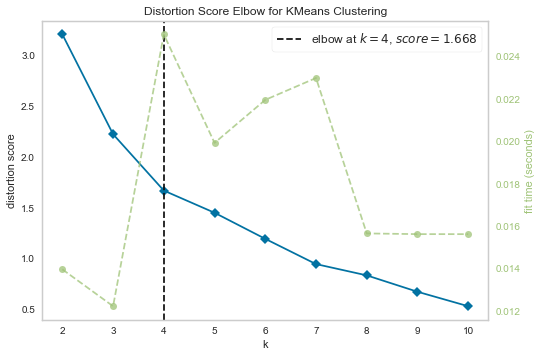

In [21]:
data_for_clustering = ecu_grouped.drop('City', 1)
model = KElbowVisualizer(KMeans(random_state=0), k=10) # Model = KMeans, # clusters = 20
model.fit(data_for_clustering)
model.show()

Knowing that the elbow has been placed at _Number of clusters = **4**_, then we continue safely:

In [22]:
k = 4 # set number of clusters
kmeans = KMeans(n_clusters=k, random_state=0).fit(ecu_grouped.drop('City', 1)) # Perform the clustering using Scikit-Learn

Finally I obtain a full report of the venues in Ecuador city, as well as the "type" of market the city belongs, as follows:

In [23]:
df_final = pd.merge(left=df,right=df_rep_top,on='City')
df_final.drop('SearchRadius',axis=1,inplace=True)
df_final.insert(2, 'TypeOfCity', kmeans.labels_) # Insert 'TypeOfCity' based on cluster
df_final

,Province,City,TypeOfCity,Population,Latitude,Longitude,Top Venue # 1,Top Venue # 2,Top Venue # 3,Top Venue # 4
0,Azuay,Cuenca,1,329 928,-2.897040,-79.003948,Italian Restaurant,Restaurant,BBQ Joint,Latin American Restaurant
1,Bolívar,Guaranda,1,23 874,-1.592290,-79.001561,Bar,Mountain,Coffee Shop,Cocktail Bar
2,Carchi,Tulcán,1,53 558,0.811929,-77.717108,Chinese Restaurant,Food & Drink Shop,Latin American Restaurant,Hotel
3,Chimborazo,Riobamba,0,146 324,-1.673148,-78.648646,Hotel,Fast Food Restaurant,Burger Joint,Bar
4,Cotopaxi,Latacunga,1,63 842,-0.933621,-78.615049,Restaurant,Pizza Place,Hotel,Fried Chicken Joint
5,El Oro,Machala,1,231 260,-3.258749,-79.959513,Seafood Restaurant,Hotel,Gym,Fast Food Restaurant
6,Esmeraldas,Esmeraldas,1,154 035,0.966815,-79.652385,Hotel,Sandwich Place,Seafood Restaurant,Women's Store
7,Galápagos,Puerto Baquerizo Moreno,1,6672,-0.902599,-89.610191,Restaurant,Nightclub,Hostel,Sushi Restaurant
8,Guayas,Guayaquil,1,2 278 691,-2.189907,-79.887726,Seafood Restaurant,Coffee Shop,Hotel,Latin American Restaurant
9,Imbabura,Ibarra,1,131 856,0.347842,-78.117359,Hotel,Pizza Place,Cocktail Bar,Seafood Restaurant


If we want to store the results, to share with stakeholders or similar:

In [24]:
df_final.to_excel("Report - Top 4 venues, in Ecuador Capital Cities.xlsx",index=False)

The file looks consistent with the dataframe we previously obtained:

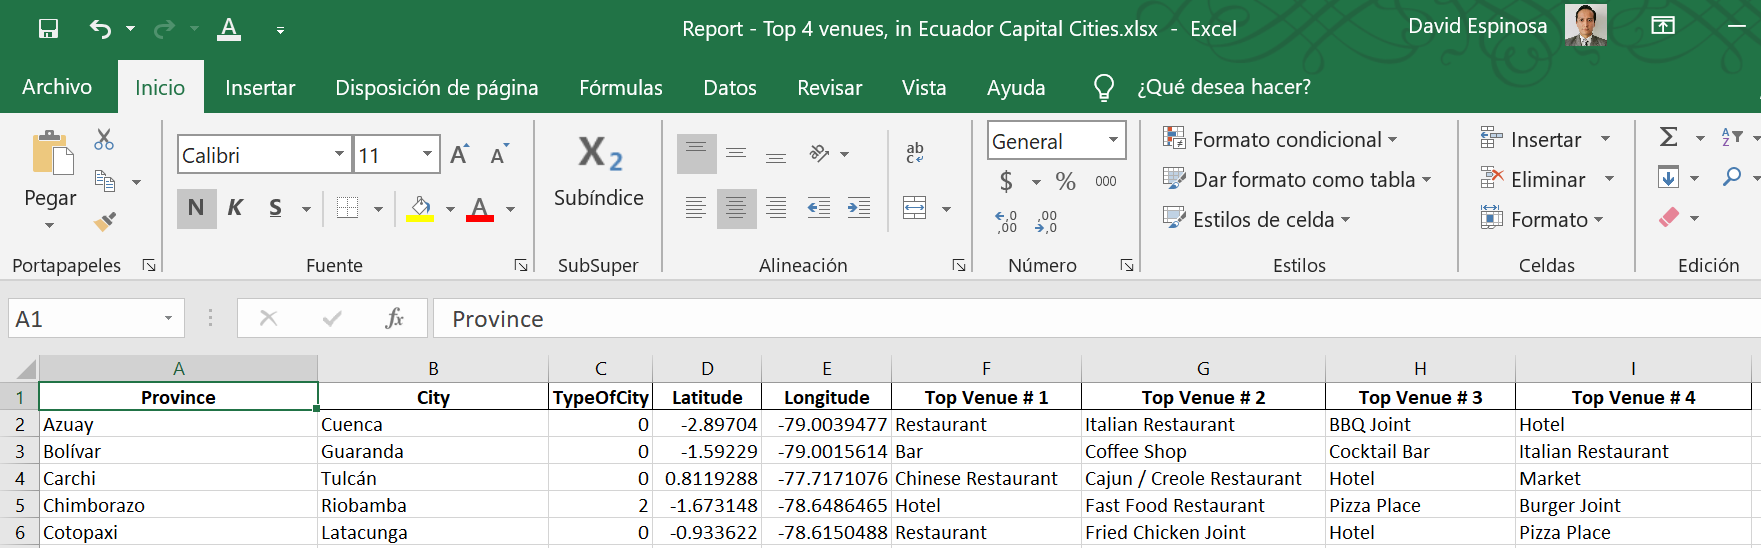

Let's check how those clusters look in the map:

In [25]:
latitude, longitude = -0.859096, -84.888436
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['City'], df_final['TypeOfCity']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's look if we can extract some observation about the venues in each cluster:

In [26]:
def visual_venues_in_cluster(df_final,which_cluster,lim=10,savefig=False):
    
    # Obtain only the venues on this cluster:
    a = df_final[df_final['TypeOfCity'] == which_cluster].iloc[:,6:].reset_index().drop('index',axis=1) 
    
    # Count the ocurrences of venues in this cluster:
    b = pd.value_counts(a.values.ravel()).to_frame().reset_index().rename(columns={'index':'Venue',0:'Count'})

    title_size, lxtp_size, barwidth = 20, 18, 0.8 # Font size
    del_spine_sides = ['top','bottom','left','right'] # Which borders to eliminate on the frame (spines)

    r = lambda: random.randint(0,255)                 # To generate random colors every time this function is called
    color = '#%02X%02X%02X' % (r(),r(),r())

    plt.figure()
    plt.rcParams["axes.grid"] = False
    ax = b.head(lim).plot(x='Venue',y='Count',kind='barh',figsize=(20,8),color = (color),width = 0.8)
    plt.gca().invert_yaxis()                          # Result were swapped along vertical axis, to compensate

    ax.set_title('Most popular venues in cluster {}'.format(which_cluster),fontdict={'fontsize':title_size})
    ax.legend(fontsize=lxtp_size)                     # Setting legend font size (14)
    ax.tick_params(axis='x',labelsize=lxtp_size)      # Setting xticks font size (14)
    ax.xaxis.set_visible(False)                       # Hiding yaxis labels
    ax.yaxis.label.set_size(18)
    for side in del_spine_sides:                      # Hiding 'spines' in all sides
        ax.spines[side].set_visible(False)
    plt.yticks(fontsize = lxtp_size)
    rects = ax.patches # Provides (x,y) position, width, heigth & angle af ALL the bars

    for rect in rects:                                # Adding labels on top of each bar
            width = rect.get_width()
            ax.annotate('Count:{}'.format(width),          # COMPLETELY DIFFERENT THAN kind='bar'
                        xy=(width,  rect.get_y() + rect.get_height() / 2),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='left', va='center',size = 14)
    plt.plot()
    
    if savefig:
            plt.savefig("Top {} venues in {}.jpeg".format(lim,city), dpi=150)
        
    return None

In cluster 0:

<Figure size 576x396 with 0 Axes>

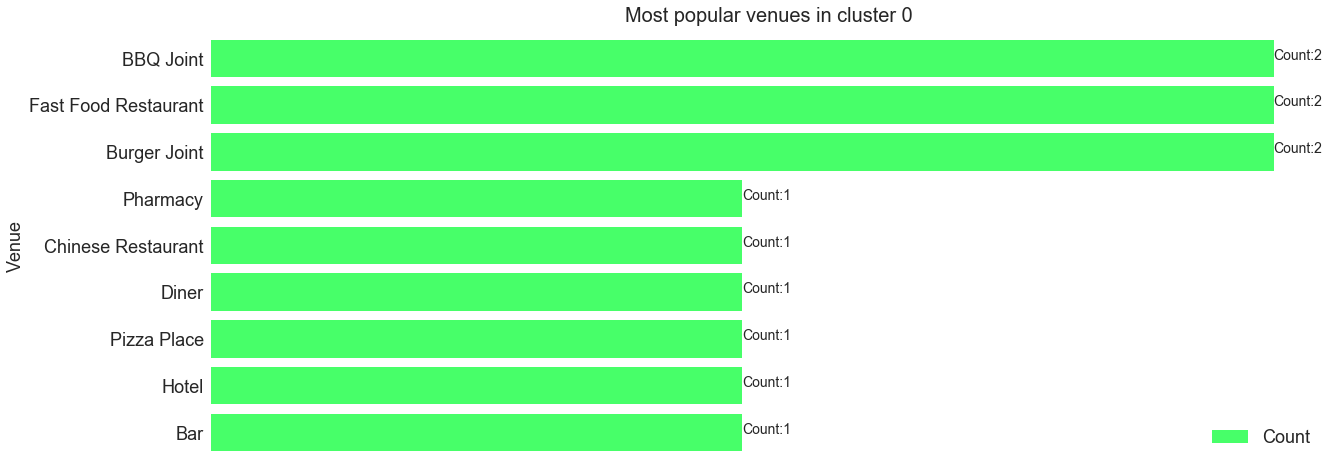

In [27]:
visual_venues_in_cluster(df_final,0)

In cluster 1:

<Figure size 576x396 with 0 Axes>

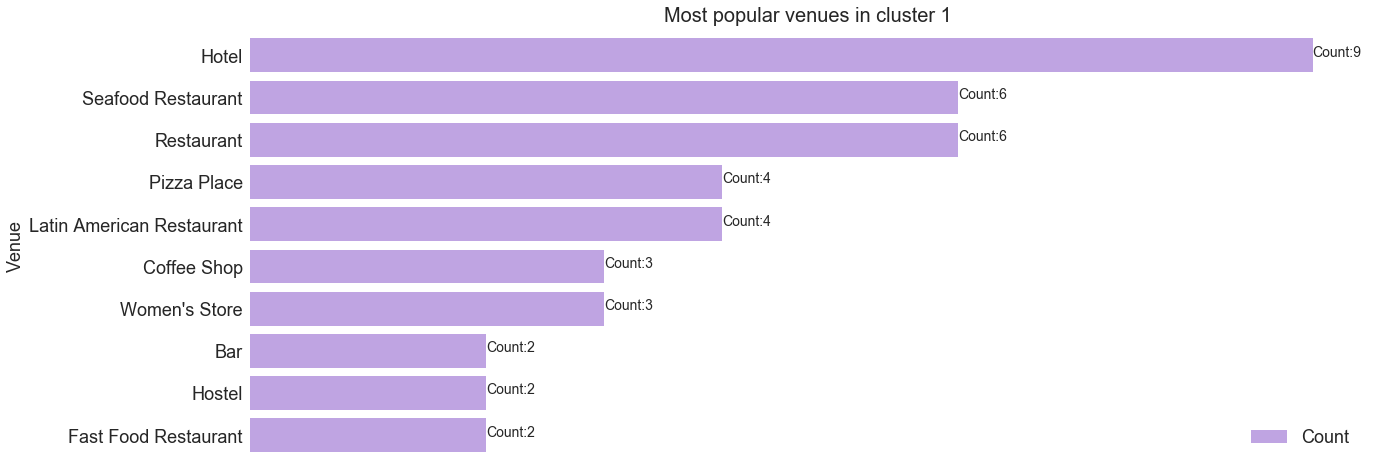

In [28]:
visual_venues_in_cluster(df_final,1)

In cluster 2:

<Figure size 576x396 with 0 Axes>

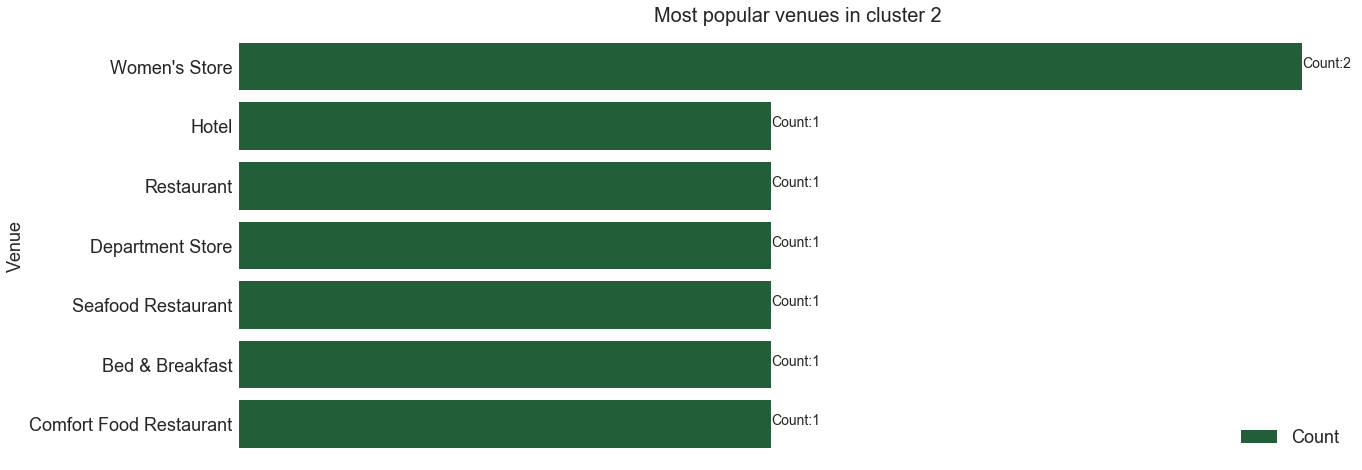

In [29]:
visual_venues_in_cluster(df_final,2)

In cluster 3:

<Figure size 576x396 with 0 Axes>

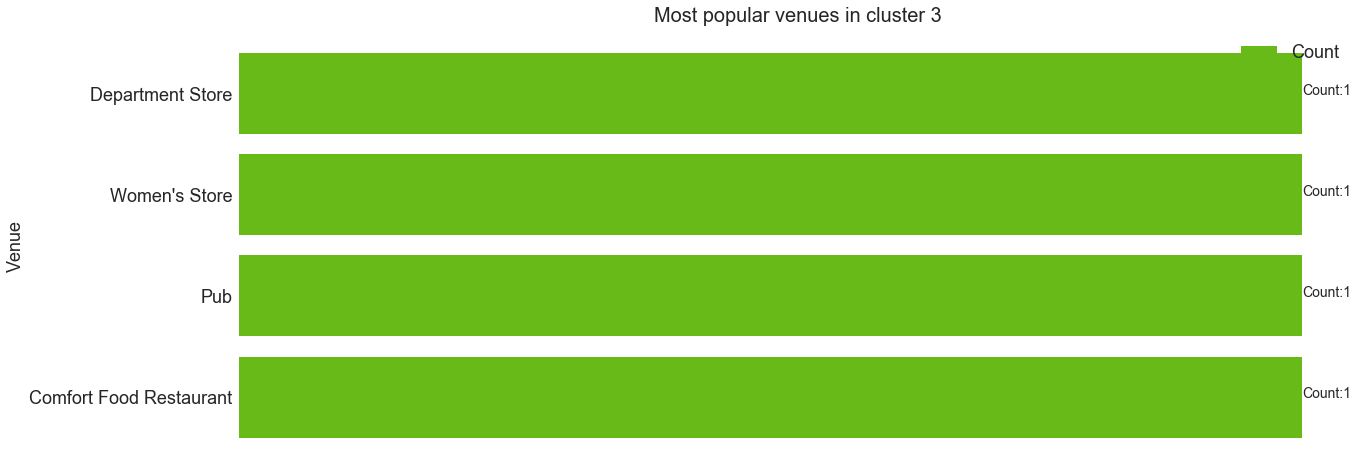

In [30]:
visual_venues_in_cluster(df_final,3)

## Results and Discussion <a class="anchor" id="results"></a>

This market analysis show that restaurants are quite popular in all of the markets, however not showing any trend, in any cluster. After the clustering process, we got 4 "City Types", where "**Type 0**" belonged to big cities which offer lots of different venue categories; "**Type 1**" belongs to smaller cities basically focused on tourism (heavy presence of hotels & restaurants alone); "**Type 2**" belongs to big cites that even being short, have a quite decent offer of several venue categories, and "**Type 3**" that are the remaining group, which is small citites with a reduced venue offer. We also saw that cities belonging to "Type 0" are the ones more popular, probably linked to the high population present in those cities.

If an investor plans to start a new business and wants to obtaine revenue as quick as possible, the most logic option would be moving to those cities different than "Type 0", because the competence will be smaller than the ones in "Type 0". Plus, to provide hints as to what to choose, we could tweak the created function "get_ecu_top_venues_report", setting its argument "popular_venues" to "False".

## Conclusion <a class="anchor" id="conclusion"></a>

This market analysis wanted to provide general hints about the most popular venues already present in the Ecuadorian Capital cities, and therefore obtain _interesting_ venue categorieson what to invest; it also provided some ideas about the "Market Types" each of those cities has, so the new investor is generally aware about what kind of market his home town is, what would he / she need pick as venue category, to start a new business, and even enables to grasp knowledge about other cities's market, if he feel daring and wants to start over in a different side.

Some facts that impacted however to this study, were:

1. People is not used to take some time to provide deep feedback about the places they visit, and so the database of existing venues was relatively small, even when this might no be the actual reality in those markets.
2. Specifically speaking about the general categories "Restauran" & "Hotel", we saw that their presence is larger than other kinds of venues; if something more "specific" would need to be grasped (i.e., what type of restauran is more popular in some city), then a further study should be done, focusing the efforts in that specific city, and that specific venue category.
3. The previous suggestion is limited by the first one, so this study would limited to be done in those cities that have a large population, and a high venue offer (i.e., according to this study, only those cities of "Type 0" and "Type 2").

In [32]:
!jupyter trust CapstoneTheBattleOfNeighborhoods.ipynb

Notebook already signed: CapstoneTheBattleOfNeighborhoods.ipynb
